In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 将画图部分的字体统一为Arial
from matplotlib import rcParams
config = {
    "font.family":'Arial',  # 设置字体类型
    "axes.unicode_minus": False #解决负号无法显示的问题
}
rcParams.update(config)

# GCD.txt的数据具有多列，每一列数据的意义如下：
# Time/sec, Potential/V, Step, Cycle, Current/A, ChargeCapacity(Ah), DischargeCapacity(Ah), ChargeEnergy(Wh), DischargeEnergy(Wh), dV/dt(V/s)
# 每个step代表一个充电或放电过程，因此可以根据step来对数据进行分组。
# coordinates列表将包含前四列数据。

# specific_current为比电流，单位为A/g
specific_current = 10
coordinates = []

with open('GCD.txt', 'r') as file:
    for line in file:
        # 移除行末的换行符并使用逗号分隔符分割行
        parts = line.strip().split(',')
        
        # 确保每行包含的数据量正确
        if len(parts) == 10:
            # 将前四个数据转换为浮点数，并创建坐标点
            try:
                time = float(parts[0])
                potential = float(parts[1])
                step = float(parts[2])
                cycle = float(parts[3])
                coordinate = (time, potential, step, cycle)
                coordinates.append(coordinate)
            except ValueError:
                print(f"无法解析行：{line}")

# 创建一个矩阵用来存储数据，这个矩阵具有5行，
# 第一行是cycle的值，第二行是这个cycle中time的最小值，
# 第三行是这个cycle中potential达到最大值时的time值，
# 第四行是这个cycle中time的最大值，第五行是这个cycle中Potential的最值的差
# 行数a = 5，列数rows是cycle的数量
a = 5 
rows = int(max(coordinate[3] for coordinate in coordinates))
matrix = [[0 for i in range(rows)] for j in range(a)]
for i in range(rows):
    matrix[0][i] = i + 1


# 创建一个字典用于存储每个不同step值对应的最大和最小time值
cycle_time_data = {}

# 遍历coordinates列表
for coordinate in coordinates:
    cycle_value = coordinate[3]
    time_value = coordinate[0]

    if cycle_value not in cycle_time_data:
        # 如果step值不在字典中，添加一个新的条目
        cycle_time_data[cycle_value] = {'max_time': time_value, 'min_time': time_value}
    else:
        # 更新字典中的max_time和min_time值
        cycle_time_data[cycle_value]['max_time'] = max(cycle_time_data[cycle_value]['max_time'], time_value)
        cycle_time_data[cycle_value]['min_time'] = min(cycle_time_data[cycle_value]['min_time'], time_value)

# 遍历字典并输出结果
for cycle_value, time_values in cycle_time_data.items():
    max_time = time_values['max_time']
    min_time = time_values['min_time']
    for i in range(rows):
        if cycle_value ==  matrix[0][i]:
            matrix[1][i] = min_time
            matrix[3][i] = max_time

# 创建一个字典用于存储cycle值对应的time和potential
cycle_time_potential = {}  

# 遍历coordinates列表
for coordinate in coordinates:
    cycle_value = coordinate[3]
    time_value = coordinate[0]
    potential_value = coordinate[1]

    if cycle_value not in cycle_time_potential:
        # 如果cycle值不在字典中，添加一个新的条目
        cycle_time_potential[cycle_value] = {'time': time_value, 'potential': potential_value}
    else:
        # 检查当前potential是否大于字典中的potential
        if potential_value > cycle_time_potential[cycle_value]['potential']:
            cycle_time_potential[cycle_value] = {'time': time_value, 'potential': potential_value}

# 遍历字典并输出结果
for cycle_value, values in cycle_time_potential.items():
    max_potential_time = values['time']
    max_potential = values['potential']
    for i in range(rows):
        if cycle_value ==  matrix[0][i]:
            matrix[2][i] = max_potential_time

# 创建一个字典用于存储cycle值对应的potential的最大值和最小值
cycle_potential = {}  

# 遍历coordinates列表
for coordinate in coordinates:
    cycle_value = coordinate[3]
    potential_value = coordinate[1]

    if cycle_value not in cycle_potential:
        # 如果cycle值不在字典中，添加一个新的条目
        cycle_potential[cycle_value] = {'max_potential': potential_value, 'min_potential': potential_value}
    else:
        # 检查当前potential是否大于字典中的max_potential
        if potential_value > cycle_potential[cycle_value]['max_potential']:
            cycle_potential[cycle_value]['max_potential'] = potential_value
        # 检查当前potential是否小于字典中的min_potential
        if potential_value < cycle_potential[cycle_value]['min_potential']:
            cycle_potential[cycle_value]['min_potential'] = potential_value

# 计算并输出差值
cycle_differences = {}  # 存储每个cycle的最大和最小potential差值
for cycle_value, values in cycle_potential.items():
    max_potential = values['max_potential']
    min_potential = values['min_potential']
    difference = max_potential - min_potential
    cycle_differences[cycle_value] = difference

# 遍历差值字典并输出结果
for cycle_value, difference in cycle_differences.items():
    for i in range(rows):
        if cycle_value ==  matrix[0][i]:
            matrix[4][i] = difference

matrix = [row[1:-1] for row in matrix]
matrix[0] = [x - 1 for x in matrix[0]]

# 计算比电容，为矩阵的第六行
Cp = []

for col_index in range(len(matrix[0])):
    numerator = matrix[3][col_index] - matrix[2][col_index]
    denominator = matrix[4][col_index]
    
    # 防止除以0错误
    if denominator != 0:
        result = specific_current * numerator / denominator
    else:
        result = None
    
    # 添加结果到新行
    Cp.append(result)

matrix.append(Cp)

CE = []

for col_index in range(len(matrix[0])):
    numerator = matrix[3][col_index] - matrix[2][col_index]
    denominator = matrix[2][col_index] - matrix[1][col_index]
    
    # 防止除以0错误
    if denominator != 0:
        result = specific_current * numerator / denominator
    else:
        result = None
    
    # 添加结果到新行
    CE.append(result)

print(CE)
matrix.append(CE)

# 计算平均放电比电容
Cp_average = sum(matrix[5][1:])/len(matrix[5][1:])


#计算电容保持率，作为第八行，计算最终电容保持率
row_index = 5
row_to_modify = matrix[row_index]
first_element = row_to_modify[0]
CR = [x / first_element for x in row_to_modify]
matrix.append(CR)

CR_final = 100*matrix[7][-1]



#计算平均库仑效率
CE_average = 100*sum(matrix[6][1:])/len(matrix[6][1:])


#计算充电比电容与平均充电比电容
Cpn = []

for col_index in range(len(matrix[0])):
    numerator = matrix[2][col_index] - matrix[1][col_index]
    denominator = matrix[4][col_index]
    
    # 防止除以0错误
    if denominator != 0:
        result = specific_current * numerator / denominator
    else:
        result = None
    
    # 添加结果到新行
    Cpn.append(result)

matrix.append(Cpn)

Cpn_average = sum(matrix[8][1:])/len(matrix[8][1:])

print("平均充电比电容Cp=", Cpn_average, "F/g")
print("平均放电比电容Cp=", Cp_average, "F/g")
print("最终电容保持率", CR_final, "%")
print("平均库仑效率", CE_average, "%")

# 打印更新后的矩阵，包括新行
for row in matrix:
    print(row)

# 输出电容保持率的图
plt.plot(matrix[0][1:], matrix[7][1:])
plt.xlabel('Cycle Number')
plt.ylabel('Capacitance retention(%)')
plt.title('')
plt.xlim((0, 1000))
plt.ylim((0, 1.2))
plt.grid(True)
plt.show()

In [ ]:
# 画第二个周期的充放电曲线

cycle_2_coordinates = [coord for coord in coordinates if coord[3] == 2]

time_list = [coord[0] for coord in cycle_2_coordinates]
potential_list = [coord[1] for coord in cycle_2_coordinates]

# 让time的每个值都减去第一个值
first_time_value = time_list[0]
time_list = [time - first_time_value for time in time_list]
# 绘制图表
plt.plot(time_list, potential_list, label='Cycle 2')
plt.xlabel('Time')
plt.ylabel('Potential')
plt.xlim((0, 1000))
plt.ylim((0, 0.6))
plt.title('Time vs Potential for Cycle 2')
plt.legend()
plt.show()

Cycle number: 1.0 Specific Current: 10.0 A/g 	 Cp_first5: 420.77 F/g 	 Cp_final5: 333.41 F/g 	  Capacitance retention: 79.24 %
Cycle number: 2.0 Specific Current: 10.0 A/g 	 Cp_first5: 333.93 F/g 	 Cp_final5: 306.43 F/g 	  Capacitance retention: 91.77 %
Cycle number: 3.0 Specific Current: 10.0 A/g 	 Cp_first5: 304.16 F/g 	 Cp_final5: 296.51 F/g 	  Capacitance retention: 97.49 %
Cycle number: 4.0 Specific Current: 10.0 A/g 	 Cp_first5: 296.06 F/g 	 Cp_final5: 284.22 F/g 	  Capacitance retention: 96.00 %
Cycle number: 5.0 Specific Current: 10.0 A/g 	 Cp_first5: 282.68 F/g 	 Cp_final5: 280.54 F/g 	  Capacitance retention: 99.24 %
Cycle number: 6.0 Specific Current: 10.0 A/g 	 Cp_first5: 280.00 F/g 	 Cp_final5: 311.82 F/g 	  Capacitance retention: 111.36 %
Cycle number: 7.0 Specific Current: 10.0 A/g 	 Cp_first5: 311.24 F/g 	 Cp_final5: 297.03 F/g 	  Capacitance retention: 95.43 %
Cycle number: 8.0 Specific Current: 10.0 A/g 	 Cp_first5: 297.81 F/g 	 Cp_final5: 296.72 F/g 	  Capacitance re

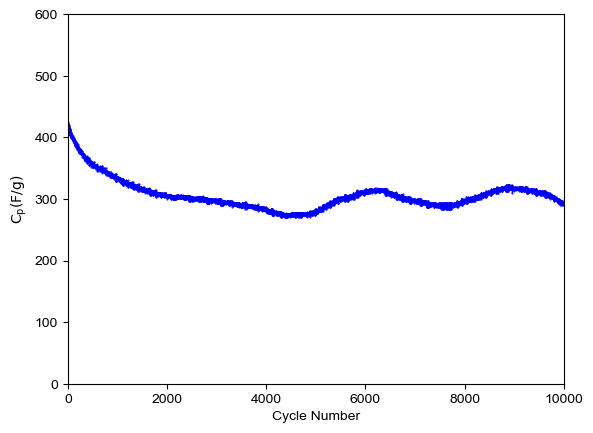

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rcParams
config = {
    "font.family":'Arial',  # 设置字体类型
    "axes.unicode_minus": False  #解决负号无法显示的问题
}
rcParams.update(config)

# 文件目录路径
directory = r'G:\Liazulene\电化学数据\LA044\044-5'

final_list=[]
Cp_list=[]
Cpdraw_list=[]

txt_files = [file for file in os.listdir(directory) if file.startswith('GCD-') and file.endswith('c.txt') ]

for txt_file in txt_files:
    file_path = os.path.join(directory, txt_file)
    # 解析文件名中的扫描速率
    specific_current = int(txt_file.split('GCD-')[1].split('_')[0])/10  
    cycle_number = int(txt_file.split('_')[1].split('c')[0])
    coordinates = []

    with open(file_path, 'r') as file:
        # 跳过无效行
        line = file.readline().strip()
        while not line.startswith('Time/sec'):
            line = file.readline().strip()
        
        for line in file:
                if line.startswith('Summary:'):
                    break  # 遇到无效数据的开头，跳出循环
            # 移除行末的换行符并使用逗号分隔符分割行
                parts = line.strip().split(',')
            
            # 确保每行包含的数据量正确
                if len(parts) == 10:
                # 将前四个数据转换为浮点数，并创建坐标点
                    try:
                        time = float(parts[0])
                        potential = float(parts[1])
                        step = float(parts[2])
                        cycle = float(parts[3])
                        coordinate = (time, potential, step, cycle)
                        coordinates.append(coordinate)
                    except ValueError:
                        print(f"无法解析行：{line}")

    # 创建一个矩阵用来存储数据，这个矩阵具有5行，
    # 第一行是cycle的值，第二行是这个cycle中time的最小值，
    # 第三行是这个cycle中potential达到最大值时的time值，
    # 第四行是这个cycle中time的最大值，第五行是这个cycle中Potential的最值的差
    # 行数a = 5，列数rows是cycle的数量
    a = 5 
    rows = int(max(coordinate[3] for coordinate in coordinates))
    matrix = [[0 for i in range(rows)] for j in range(a)]
    for i in range(rows):
        matrix[0][i] = i + 1


    # 创建一个字典用于存储每个不同step值对应的最大和最小time值
    cycle_time_data = {}

    # 遍历coordinates列表
    for coordinate in coordinates:
        cycle_value = coordinate[3]
        time_value = coordinate[0]

        if cycle_value not in cycle_time_data:
            # 如果step值不在字典中，添加一个新的条目
            cycle_time_data[cycle_value] = {'max_time': time_value, 'min_time': time_value}
        else:
            # 更新字典中的max_time和min_time值
            cycle_time_data[cycle_value]['max_time'] = max(cycle_time_data[cycle_value]['max_time'], time_value)
            cycle_time_data[cycle_value]['min_time'] = min(cycle_time_data[cycle_value]['min_time'], time_value)

    # 遍历字典并输出结果
    for cycle_value, time_values in cycle_time_data.items():
        max_time = time_values['max_time']
        min_time = time_values['min_time']
        for i in range(rows):
            if cycle_value ==  matrix[0][i]:
                matrix[1][i] = min_time
                matrix[3][i] = max_time

    # 创建一个字典用于存储cycle值对应的time和potential
    cycle_time_potential = {}  

    # 遍历coordinates列表
    for coordinate in coordinates:
        cycle_value = coordinate[3]
        time_value = coordinate[0]
        potential_value = coordinate[1]

        if cycle_value not in cycle_time_potential:
            # 如果cycle值不在字典中，添加一个新的条目
            cycle_time_potential[cycle_value] = {'time': time_value, 'potential': potential_value}
        else:
            # 检查当前potential是否大于字典中的potential
            if potential_value > cycle_time_potential[cycle_value]['potential']:
                cycle_time_potential[cycle_value] = {'time': time_value, 'potential': potential_value}

    # 遍历字典并输出结果
    for cycle_value, values in cycle_time_potential.items():
        max_potential_time = values['time']
        max_potential = values['potential']
        for i in range(rows):
            if cycle_value ==  matrix[0][i]:
                matrix[2][i] = max_potential_time

    # 创建一个字典用于存储cycle值对应的potential的最大值和最小值
    cycle_potential = {}  

    # 遍历coordinates列表
    for coordinate in coordinates:
        cycle_value = coordinate[3]
        potential_value = coordinate[1]

        if cycle_value not in cycle_potential:
            # 如果cycle值不在字典中，添加一个新的条目
            cycle_potential[cycle_value] = {'max_potential': potential_value, 'min_potential': potential_value}
        else:
            # 检查当前potential是否大于字典中的max_potential
            if potential_value > cycle_potential[cycle_value]['max_potential']:
                cycle_potential[cycle_value]['max_potential'] = potential_value
            # 检查当前potential是否小于字典中的min_potential
            if potential_value < cycle_potential[cycle_value]['min_potential']:
                cycle_potential[cycle_value]['min_potential'] = potential_value

    # 计算并输出差值
    cycle_differences = {}  # 存储每个cycle的最大和最小potential差值
    for cycle_value, values in cycle_potential.items():
        max_potential = values['max_potential']
        min_potential = values['min_potential']
        difference = max_potential - min_potential
        cycle_differences[cycle_value] = difference

    # 遍历差值字典并输出结果
    for cycle_value, difference in cycle_differences.items():
        for i in range(rows):
            if cycle_value ==  matrix[0][i]:
                matrix[4][i] = difference

    matrix = [row[1:-1] for row in matrix]
    matrix[0] = [x - 1 for x in matrix[0]]

    # 计算比电容，为矩阵的第六行
    Cp = []

    for col_index in range(len(matrix[0])):
        numerator = matrix[3][col_index] - matrix[2][col_index]
        denominator = matrix[4][col_index]
        
        # 防止除以0错误
        if denominator != 0:
            result = specific_current * numerator / denominator
        else:
            result = None
        
        # 添加结果到新行
        Cp.append(result)
    matrix.append(Cp)


    CE = []

    for col_index in range(len(matrix[0])):
        numerator = matrix[3][col_index] - matrix[2][col_index]
        denominator = matrix[2][col_index] - matrix[1][col_index]
        
        # 防止除以0错误
        if denominator != 0:
            result = specific_current * numerator / denominator
        else:
            result = None
        
        # 添加结果到新行
        CE.append(result)

    # print(CE)
    matrix.append(CE)

    # 计算平均放电比电容
    Cp_average = sum(matrix[5][1:])/len(matrix[5][1:])


    #计算电容保持率，作为第八行，计算最终电容保持率
    row_index = 5
    row_to_modify = matrix[row_index]
    first_element = row_to_modify[0]
    CR = [x / first_element for x in row_to_modify]
    matrix.append(CR)

    CR_final = 100*matrix[7][-1]



    #计算平均库仑效率
    CE_average = 100*sum(matrix[6][1:])/len(matrix[6][1:])


    #计算充电比电容与平均充电比电容
    Cpn = []

    for col_index in range(len(matrix[0])):
        numerator = matrix[2][col_index] - matrix[1][col_index]
        denominator = matrix[4][col_index]
        
        # 防止除以0错误
        if denominator != 0:
            result = specific_current * numerator / denominator
        else:
            result = None
        
        # 添加结果到新行
        Cpn.append(result)

    matrix.append(Cpn)
    Cp_first5 = sum(matrix[5][:5])/len(matrix[5][:5])
    Cp_final5 = sum(matrix[5][-5:])/len(matrix[5][-5:])
    capacitance_retention = Cp_final5/Cp_first5 *100
    k2 = (cycle_number, specific_current, Cp_first5, Cp_final5, capacitance_retention)
    combined_list = [cycle_number, Cp]
    final_list.append(k2)
    Cp_list.append(combined_list)

final_array = np.array(final_list)

sorted_indices = np.argsort(final_array[:, 0])
sorted_scan_list = final_array[sorted_indices]

# 提取排序后的 Sc 和 Cp 值
sorted_number = sorted_scan_list[:, 0]
sorted_sc = sorted_scan_list[:, 1]
sorted_Cpn = sorted_scan_list[:, 2]
sorted_Cp = sorted_scan_list[:, 3]
sorted_CR = sorted_scan_list[:, 4]

for num, k, Cpn, Cp ,CR in zip(sorted_number, sorted_sc, sorted_Cpn, sorted_Cp, sorted_CR):
    print("Cycle number:", num, "Specific Current:", k, "A/g", "\t Cp_first5: {:.2f}".format(Cpn), "F/g", "\t Cp_final5: {:.2f}".format(Cp),"F/g", "\t  Capacitance retention: {:.2f}".format(CR), "%")

Cp_list_sorted = sorted(Cp_list, key=lambda x: x[0])
merged_Cp_list = []
for _, Cp_list in Cp_list_sorted:
    merged_Cp_list.extend(Cp_list)

x = len(merged_Cp_list)
x_values = list(range(1, x + 1))

# 绘制图表
plt.plot(x_values, merged_Cp_list, 'b.-',linewidth=0.5, markersize=1)
plt.xlabel('Cycle Number')
plt.ylabel('$\mathrm{C_p (F/g)}$')
# plt.title('Plot of Cp_list')
plt.xlim((0, 10000))
plt.ylim((0, 600))
plt.grid(False)  # 添加网格线
plt.savefig("GCD_cycles.eps", dpi=600, format="eps")
plt.show()

